In [7]:
from Algorithm import Gaussian_Process
from Algorithm import LA_Bayessian_Quadrature
from Algorithm import Mesh
from Algorithm import Kernels
import Target_Function as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

plt.rcParams['figure.figsize'] = [12, 6]

In [8]:
opt1 = tf.Option('call', 0, 95, .25, 1.0,  15, 1)
opt2 = tf.Option('put',  1, 110, .2,  0.5,  5, 1)
portfolio = tf.OptionPortfolio(.03, 50, 150,[opt1, opt2])
D = len(portfolio.options)
func = portfolio.target_function

print(f"Analytic portfolio Δ : {func([portfolio.alter(102.0),portfolio.alter(98.0)]):,.4f}")

Analytic portfolio Δ : 6.8313


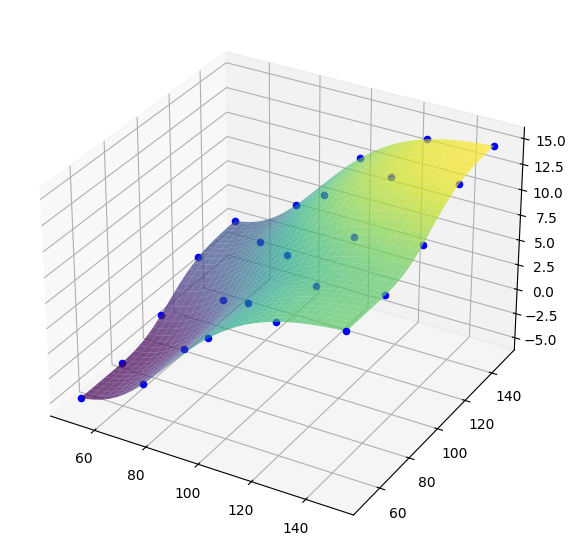

In [9]:
a = np.linspace(0., 1., 101)
b = np.linspace(0., 1., 101)
# 计算 z 值
A, B = np.meshgrid(a, b)
C = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        C[i, j] = func([A[i, j], B[i, j]])

# 4. 绘图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(portfolio.to_initial(A), portfolio.to_initial(B), C, cmap='viridis', alpha=0.7)

# 生成二维输入网格
xx = np.linspace(0., 1., 5)
yy = np.linspace(0., 1., 5)
xxx, yyy = np.meshgrid(xx, yy)
X = np.vstack([xxx.ravel(), yyy.ravel()]).T
# 生成 Y
Y = np.array([func(x) for x in X])


for idx, i in enumerate(X):
    ax.scatter(portfolio.to_initial(i[0]),
               portfolio.to_initial(i[1]),
               Y[idx], color='blue', s=20)
plt.show()

In [10]:
beta = np.concatenate([
    np.array([-0.5]),
    np.random.uniform(-2, 0, size=11 * D)
])

In [11]:
mesh1 = Mesh.get_points_Sobol(X,_)

GP = Gaussian_Process.GaussianProcess(Kernels.K_lin_mat2_10,beta,X,Y,mesh = mesh1)


In [12]:
GPs, int_params = LA_Bayessian_Quadrature.ABC_D(
    func,                # 你定义的目标函数（black-box，输入 [x1, x2]，返回 float）
    GP,                  # 你初始化好的 GaussianProcess 对象
    Mesh.get_points_Sobol,   # 用于生成新候选点的函数（mesh.py 中的默认高维函数）
    n=30,                # 进行 30 次自适应采样（共 31 个点）
    lambd=[30, 1],       # 正则项参数，推荐默认即可
    point_mesh = mesh1
)

No threshold given, optimising beta at each step.
Step  1  of  31
(mean,var):  [5.10498774 0.09745598]
Step  2  of  31
(mean,var):  [5.19106962 0.08610006]
Step  3  of  31
(mean,var):  [5.34536131 0.07538366]
Step  4  of  31
(mean,var):  [5.41465788 0.06364352]
Step  5  of  31
(mean,var):  [5.42149778 0.05231641]
Step  6  of  31
(mean,var):  [5.59945023 0.04274846]
Step  7  of  31
(mean,var):  [5.68404447 0.03462516]
Step  8  of  31
(mean,var):  [5.6788819 0.0296713]
Step  9  of  31
(mean,var):  [5.74030414 0.02507835]
Step  10  of  31
(mean,var):  [5.74941971 0.02063427]
Step  11  of  31
(mean,var):  [5.74242319 0.01690911]
Step  12  of  31
(mean,var):  [5.73109952 0.01403112]
Step  13  of  31
(mean,var):  [5.77015217 0.01045924]
Step  14  of  31
(mean,var):  [5.77847581 0.00783139]
Step  15  of  31
(mean,var):  [5.78030985 0.00677165]
Step  16  of  31
(mean,var):  [5.77835279e+00 5.72286906e-03]
Step  17  of  31
(mean,var):  [5.7910839e+00 4.8546017e-03]
Step  18  of  31
(mean,var): 

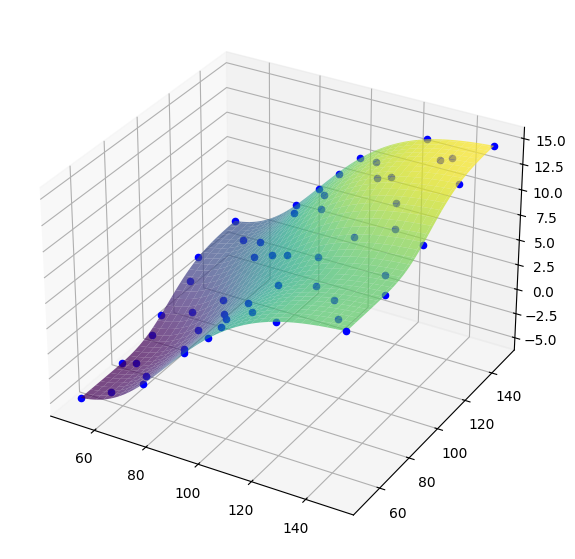

In [13]:
final_GP = GPs[-1]
pa = np.linspace(0., 1., 101)
pb = np.linspace(0., 1., 101)
PA, PB = np.meshgrid(pa, pb)
PC = np.zeros_like(PA)
for i in range(PA.shape[0]):
    for j in range(PA.shape[1]):
        PC[i, j] = func([PA[i, j], PB[i, j]])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(portfolio.to_initial(PA), portfolio.to_initial(PB), PC, cmap='viridis', alpha=0.7)


px = []
for i in range(len(final_GP.X.T[0])):
    px.append([final_GP.X.T[0][i], final_GP.X.T[1][i]])
py = [func(i) for i in px]


for idx, i in enumerate(px):
    ax.scatter(portfolio.to_initial(i[0]),portfolio.to_initial(i[1]), py[idx], color='blue', s=20)
plt.show()

In [14]:
print(np.sqrt(int_params[-1][1]/int_params[-1][0]))

0.004965685693613801
